In [1]:
# Order is important
#import sklearn
#from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from tensorflow.keras.models import Model
from tensorflow import keras
#from matplotlib import pyplot as plt
import numpy as np



from skimage import io




In [42]:
df = pd.read_csv('./files/TransitionMyUnet_40.csv')
df.head()

,Unnamed: 0,loss,dice_coefficient,val_loss,val_dice_coefficient
0,0,0.177651,0.106580,0.190679,0.104574
1,1,0.174015,0.114658,0.186054,0.107081
2,2,0.172567,0.114572,0.182896,0.107781
3,3,0.170567,0.115145,0.181563,0.111719
4,4,0.167207,0.120492,0.180382,0.109377


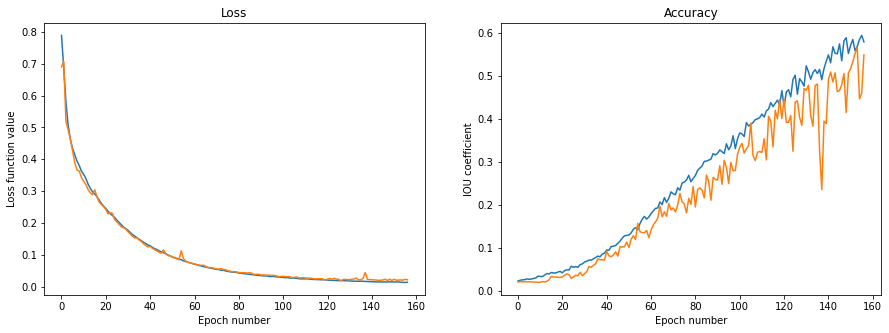

In [38]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('./files/SummerMyUnet_42.csv')
df.head()
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))

metricsName = 'dice_coefficient'

#titles
ax_loss.set_title('Loss')
ax_acc.set_title('Accuracy')

# axes label
ax_loss.set_xlabel('Epoch number')
ax_loss.set_ylabel('Loss function value')
ax_acc.set_xlabel('Epoch number')
ax_acc.set_ylabel('IOU coefficient')

ax_loss.plot(df[df.columns[0]].values, df.loss, label="Train loss")
ax_loss.plot(df[df.columns[0]].values, df.val_loss, label="Validation loss")
ax_acc.plot(df[df.columns[0]].values, df[metricsName], label="Train accuracy")
ax_acc.plot(df[df.columns[0]].values, df[f"val_{metricsName}"], label="Validation accuracy")

In [30]:
#import tensorflow.keras.backend as K
#def dice_coefficient(y_true, y_pred, smooth=1):
#    y_true_f = K.flatten(y_true)
#    y_pred_f = K.flatten(y_pred)
#    intersection = K.sum(y_true_f * y_pred_f)
#    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
model = keras.models.load_model('./files/TransitionMyUnet_40.h5',compile=False)

In [34]:
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 256, 256, 5)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 3)       18        
_________________________________________________________________
model_11 (Model)             multiple                  23752273  
Total params: 23,752,291
Trainable params: 23,748,259
Non-trainable params: 4,032
_________________________________________________________________


            # x with features
            # channel indexes
            # mask - 0 
            # NEW
            #["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
            #[ 1,     2,    3,    4,    5,    6,    7,    8,    9,    10,   11,   12,   13  ]
            # OLD
            #["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
            #[ 14,    15,   16,   17,   18,   19,   20,   21,   22,   23,   24,   25,   26  ]

Text(0.5, 1.0, 'Ground trouth')

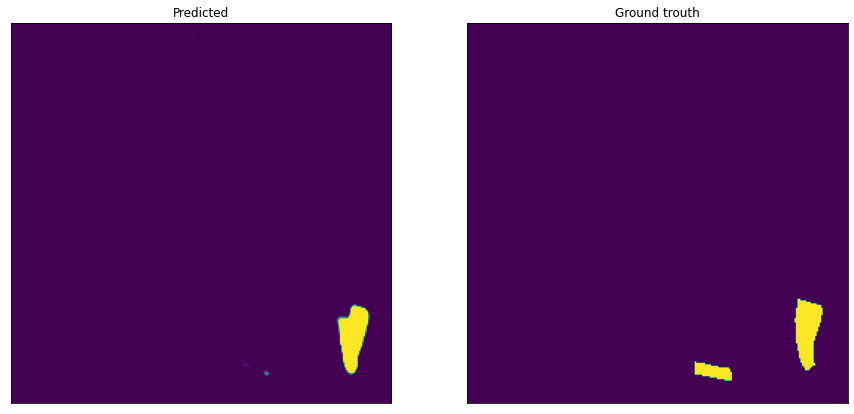

In [50]:
testImg = (
'../../ds/tiles_256_256_27_test/T40VEL_pair_2.tif_6768_6733_with_object.tif')

mask = io.imread(testImg)[:,:,0]
img = io.imread(testImg)/65536

#add zeros mask to fill empty mask channel
img = np.insert(img,0, np.zeros((256,256)),axis=2)
#print (img.shape)
            
toPredict = np.array(
                np.dstack([
                    # separate new
                    img[:,:,4],
                    #img[:,:,5],
                    #img[:,:,6],
                    #img[:,:,7],
                    img[:,:,8],
                    #img[:,:,13],
                    # separate old
                    img[:,:,17],
                    #img[:,:,18],
                    #img[:,:,19],
                    #img[:,:,20],
                    img[:,:,21],
                    #img[:,:,26],
                    #
                    img[:,:,4] - img[:,:,17], # dif red
                    img[:,:,17] - img[:,:,4], # dif for transitionChange
                    #img[:,:,8],
                    #img[:,:,21],
                    #img[:,:,13],
                    img[:,:,8] - img[:,:,21],
                    img[:,:,21] - img[:,:,8],
                    #(
                    #    (img[:,:,8] - img[:,:,4]) /((img[:,:,8] + img[:,:,4])+ 0.0001)- # new ndvi
                    #    (img[:,:,21] - img[:,:,17])/((img[:,:,21] + img[:,:,17])+0.0001) # old ndvi
                    #), # ndvi diff
                    #swvi dif
                    #(
                    #    (img[:,:,8] - img[:,:,13]) /((img[:,:,8] + img[:,:,13])+0.0001)-   # new swir
                    #    (img[:,:,21] - img[:,:,26])/((img[:,:,21] + img[:,:,26])+0.0001)  # old swir
                        
                    #),
                    #swvi dif 
                    #(
                    #    (img[:,:,21] - img[:,:,26])/((img[:,:,21] + img[:,:,26])+0.0001) -
                    #    (img[:,:,8] - img[:,:,13]) /((img[:,:,8] + img[:,:,13])+0.0001)   # new swir
                         # old swir
                        
                    #),
                    
                    img[:,:,13],
                    img[:,:,26],
                    img[:,:,13] - img[:,:,26],
                    img[:,:,26] - img[:,:,13], # dif for transitionChange
                    img[:,:,12], # dif for transitionChange
                    img[:,:,25], # dif for transitionChange
                    img[:,:,12] - img[:,:,25], # dif for transitionChange
                    img[:,:,25] - img[:,:,12], # dif for transitionChange
                    #(get_value_by_extent(imagePath))/100.0
                    
                ]).astype('float32'))

testPrediction = model.predict(np.array([toPredict]))

#display output
fig,axes = plt.subplots(ncols=2,figsize=(15,15))

#display without probality condition
#axes[0].imshow(np.where(testPrediction[0].astype('float32')>0.5,1,0))

#display with probality condition
axes[0].imshow(testPrediction[0].astype('float32'))
axes[0].xaxis.set_ticks([])
axes[0].yaxis.set_ticks([])
axes[0].set_title('Predicted')


axes[1].imshow(mask)
axes[1].xaxis.set_ticks([])
axes[1].yaxis.set_ticks([])
axes[1].set_title('Ground trouth')

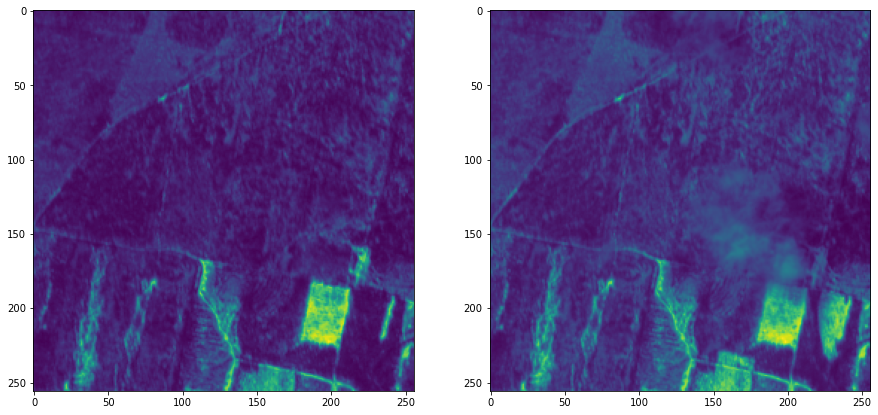

In [51]:
from skimage.util import img_as_ubyte

#testImg = '../../ds/tiles_256_256_27_test/T39VXH_pair_1.tif_5056_1883_with_object.tif'
img = io.imread(testImg)/65536
RGB = np.array(
                np.dstack([
                    img[:,:,], 
                    img[:,:,3],
                    img[:,:,2],
                ])
)
fig,axes = plt.subplots(ncols=2,figsize=(15,15))

#axes[0]("off")
axes[0].imshow(img[:,:,17])
axes[1].imshow(img[:,:,4])
#plt.axis('off')
#plt.imshow(img_as_ubyte(RGB))
#plt.show()

In [5]:
import os
import pandas as pd
import numpy as np
for csvFile in os.listdir('./files/'):
    if csvFile.endswith('.csv'):
        df = pd.read_csv(f'./files/{csvFile}')
        print (csvFile, np.max(df.val_dice_coefficient.values))

data.csv 0.3283189535140991
modelSummerNoDropout.csv 0.4336182475090027
modelSummerWithDropout.csv 0.4131618142127991
modelSummerWithDropoutWithAug.csv 0.3094292879104614
modelSummerWithDropoutWithSWVI.csv 0.4378954470157623
modelSummerWithDropoutWithSWVIWithAug_1000epoch.csv 0.54620361328125
modelSummerWithoutDropoutWithSWVIWithAug_1000epoch.csv 0.54620361328125
modelWinterWithoutDropoutWithSWVIWithoutAug.csv 0.54620361328125
modelTransitionWithWithoutAug.csv 0.5019904375076294


# Save predicted image witj georeference

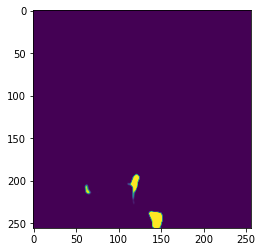

In [39]:
plt.imshow(testPrediction[0][:,:,0].astype('float32'))

In [5]:
import gdal
import osr
import os

import datetime
from osgeo import gdal_array

def predict_folder(
    model_path='./files/winterBackboneFirstTest.h5',
    inFld = '../../ds/ds_validation_256_256_26/'\
        'L1C_T40VEM_A024828_20200324T073608_L1C_T40VEM_A014132_20191120T074121/',
    outFld = '/home/andrew.tarasov1993.gmail.com/outs/geoRefPredict/'\
        'L1C_T40VEM_A024828_20200324T073608_L1C_T40VEM_A014132_20191120T074121'
):

    model = keras.models.load_model(model_path,compile=False)

    
    

    print(datetime.datetime.now())
    for img in os.listdir(inFld):
        #print (img)

        if img.endswith('.tif'):
            inImg = os.path.join(inFld,img)
            outTile = os.path.join(outFld,img)
            tileSize = 256

            rasterArray = gdal_array.LoadFile(inImg)
            #print(rasterArray.shape)
            if rasterArray.shape[1] !=256 or rasterArray.shape[2] !=256:
                #print (f"{img} - incorrect shape") 
                rasterArray = None
                continue


            #print(inImg)
            #srcDs = gdal.Open(inImg)

            testPrediction = model.predict(np.array([calcFeatures(inImg)]))       

            srcDs = gdal.Open(inImg)
            driver = gdal.GetDriverByName("GTiff")
            srsSpRef = srcDs.GetSpatialRef()

            dstDs = driver.Create(outTile,tileSize,tileSize,1,gdal.GDT_Float32)
            dstDs.SetProjection(srsSpRef.ExportToWkt())
            dstDs.SetGeoTransform(srcDs.GetGeoTransform())

            dstDs.GetRasterBand(1).WriteArray(testPrediction[0][:,:,0].astype(np.float32))
            #dstDs.FlushCache()
            dstDs = None
            src = None
    print(datetime.datetime.now())

# Batch prediction folder and merge all tile to one

In [19]:
from tensorflow import keras
from tensorflow.keras.models import Model
from skimage import io
import os
import numpy as np

In [8]:
import glob

In [49]:
predicts_folders = list(glob.glob('../../ds/ds_validation_256_256_26/otherTests/*T39VXF*'))
'''predicts_folders = (
    list(glob.glob(f'../../ds/ds_validation_256_256_26/seasonChange/*T38VPL*'))
    + list(glob.glob(f'../../ds/ds_validation_256_256_26/seasonChange/*T37WFM*'))
    + list(glob.glob(f'../../ds/ds_validation_256_256_26/seasonChange/*T39VXH*'))
    + list(glob.glob(f'../../ds/ds_validation_256_256_26/seasonChange/*T39VWF*'))
)'''

"predicts_folders = (\n    list(glob.glob(f'../../ds/ds_validation_256_256_26/seasonChange/*T38VPL*'))\n    + list(glob.glob(f'../../ds/ds_validation_256_256_26/seasonChange/*T37WFM*'))\n    + list(glob.glob(f'../../ds/ds_validation_256_256_26/seasonChange/*T39VXH*'))\n    + list(glob.glob(f'../../ds/ds_validation_256_256_26/seasonChange/*T39VWF*'))\n)"

In [50]:
predicts_folders

['../../ds/ds_validation_256_256_26/otherTests/S2B_MSIL1C_20200610T074619_N0209_R135_T39VXF_20200610T094912.SAFE_S2A_MSIL1C_20200506T074621_N0209_R135_T39VXF_20200506T105630.SAFE']

In [51]:
import glob
out_tile_fld = '/home/andrew.tarasov1993.gmail.com/outs/geoRefPredict'
out_result_fld = '/home/andrew.tarasov1993.gmail.com/outs/geoRefPredict/'
#for fld in glob.glob('../../ds/ds_validation_256_256_26/S2A*'):
for fld in predicts_folders:  
    fld_name = os.path.basename(fld)
    print(fld_name)
    out_predict_path = os.path.join(out_tile_fld, fld_name)
    if not os.path.exists(out_predict_path):
        os.mkdir(out_predict_path)
    
    predict_folder(
        model_path='./files/TransitionMyUnet_40.h5',
        inFld=fld,
        outFld=out_predict_path
    )
    
    merge_tiles(out_predict_path,os.path.join(out_result_fld, fld_name + '.tif'))

S2B_MSIL1C_20200610T074619_N0209_R135_T39VXF_20200610T094912.SAFE_S2A_MSIL1C_20200506T074621_N0209_R135_T39VXF_20200506T105630.SAFE
2021-03-03 13:18:30.445763
2021-03-03 13:23:15.777057


In [3]:
def calcFeatures(inImg):
    img = io.imread(inImg)/65536
    #add zeros mask to fill empty mask channel
    img = np.insert(img,0, np.zeros((256,256)),axis=2)
    #print (img.shape)

    toPredict = np.array(
                    np.dstack([
                     #img[:,:,21], # new red
                    #img[:,:,25], # new red
                    #img[:,:,26], # new red
                    
                    # separate new
                    img[:,:,4],
                    #img[:,:,5],
                    #img[:,:,6],
                    #img[:,:,7],
                    img[:,:,8],
                    #img[:,:,13],
                    # separate old
                    img[:,:,17],
                    #img[:,:,18],
                    #img[:,:,19],
                    #img[:,:,20],
                    img[:,:,21],
                    #img[:,:,26],
                    #
                    img[:,:,4] - img[:,:,17], # dif red
                    img[:,:,17] - img[:,:,4], # dif for transitionChange
                    #img[:,:,8],
                    #img[:,:,21],
                    #img[:,:,13],
                    img[:,:,8] - img[:,:,21],
                    img[:,:,21] - img[:,:,8],
                    #(
                    #    (img[:,:,8] - img[:,:,4]) /((img[:,:,8] + img[:,:,4])+ 0.0001)- # new ndvi
                    #    (img[:,:,21] - img[:,:,17])/((img[:,:,21] + img[:,:,17])+0.0001) # old ndvi
                    #), # ndvi diff
                    #swvi dif
                    #(
                    #    (img[:,:,8] - img[:,:,13]) /((img[:,:,8] + img[:,:,13])+0.0001)-   # new swir
                    #    (img[:,:,21] - img[:,:,26])/((img[:,:,21] + img[:,:,26])+0.0001)  # old swir
                        
                    #),
                    #swvi dif 
                    #(
                    #    (img[:,:,21] - img[:,:,26])/((img[:,:,21] + img[:,:,26])+0.0001) -
                    #    (img[:,:,8] - img[:,:,13]) /((img[:,:,8] + img[:,:,13])+0.0001)   # new swir
                         # old swir
                        
                    #),
                    
                    img[:,:,13],
                    img[:,:,26],
                    img[:,:,13] - img[:,:,26],
                    img[:,:,26] - img[:,:,13], # dif for transitionChange
                    img[:,:,12], # dif for transitionChange
                    img[:,:,25], # dif for transitionChange
                    img[:,:,12] - img[:,:,25], # dif for transitionChange
                    img[:,:,25] - img[:,:,12], # dif for transitionChange
                    #(get_value_by_extent(imagePath))/100.0

                    ]).astype('float32'))
    return toPredict

# Merge all predicted tiles to one image

In [57]:
import glob
import numpy as np

In [162]:
trOpts = gdal.TranslateOptions(outputType=gdal.GDT_Float32,
                               noData=-9999,
                               rgbExpand="gray",
                               unscale=False,
                               format="GTiff"
                              )
outDs = gdal.Translate('mosaic.tif',ds,options=trOpts)

ValueError: Received a NULL pointer.

In [4]:
def merge_tiles(inFld, outFile):
    lsTfs = glob.glob(f'{inFld}/*.tif')

    bltOpts = gdal.BuildVRTOptions()
    ds = gdal.BuildVRT('mosaic.vrt', lsTfs,options=bltOpts)
    #ds.FlushCache()

    outDs = gdal.GetDriverByName("GTiff").Create(
        outFile, 
        ds.RasterXSize,
        ds.RasterYSize,
        1,
        gdal.GDT_Float32
    )

    outDs.GetRasterBand(1).WriteArray(ds.ReadAsArray().astype(np.float32))
    srsSpRef = ds.GetSpatialRef()

    outDs.SetProjection(srsSpRef.ExportToWkt())
    outDs.SetGeoTransform(ds.GetGeoTransform())
    #outDs.FlushCache()

    ds = None
    outDs = None

In [130]:
np.max(outDs.ReadAsArray())

1.0

In [121]:
np.max(ds.ReadAsArray())

1.0

In [114]:
dir(ds)

['AddBand',
 'AdviseRead',
 'BeginAsyncReader',
 'BuildOverviews',
 'CommitTransaction',
 'CopyLayer',
 'CreateLayer',
 'CreateMaskBand',
 'DeleteLayer',
 'EndAsyncReader',
 'ExecuteSQL',
 'FlushCache',
 'GetDescription',
 'GetDriver',
 'GetFileList',
 'GetGCPCount',
 'GetGCPProjection',
 'GetGCPSpatialRef',
 'GetGCPs',
 'GetGeoTransform',
 'GetLayer',
 'GetLayerByIndex',
 'GetLayerByName',
 'GetLayerCount',
 'GetMetadata',
 'GetMetadataDomainList',
 'GetMetadataItem',
 'GetMetadata_Dict',
 'GetMetadata_List',
 'GetNextFeature',
 'GetProjection',
 'GetProjectionRef',
 'GetRasterBand',
 'GetRootGroup',
 'GetSpatialRef',
 'GetStyleTable',
 'GetSubDatasets',
 'GetTiledVirtualMem',
 'GetTiledVirtualMemArray',
 'GetVirtualMem',
 'GetVirtualMemArray',
 'RasterCount',
 'RasterXSize',
 'RasterYSize',
 'ReadAsArray',
 'ReadRaster',
 'ReadRaster1',
 'ReleaseResultSet',
 'ResetReading',
 'RollbackTransaction',
 'SetDescription',
 'SetGCPs',
 'SetGeoTransform',
 'SetMetadata',
 'SetMetadataItem',


In [139]:
np.max(gdal.Open('mosaic2.tif').ReadAsArray())

1.0

# Display RGB

In [9]:
def plot_rgb(tile, old=True, q=[0.001, 0.7], size=256):
    
   

    if old:
        shift = 0
    else:
        shift = 13
        
    blue = tile[:, :, (2 + shift)].reshape(-1, 1)
    blue_q = np.quantile(blue, q)
    blue = np.where(blue < blue_q[0], blue_q[0], blue)
    blue = np.where(blue > blue_q[1], blue_q[1], blue)

    green = tile[:, :, (3 + shift)].reshape(-1, 1)
    green_q = np.quantile(green, q)
    green = np.where(green < green_q[0], green_q[0], green)
    green = np.where(green > green_q[1], green_q[1], green)

    red = tile[:, :, (4 + shift)].reshape(-1, 1)
    red_q = np.quantile(red, q)
    red = np.where(red < red_q[0], red_q[0], red)
    red = np.where(red > red_q[1], red_q[1], red)

    mms = sklearn.preprocessing.MinMaxScaler((0, 255))

    blue = mms.fit_transform(blue).reshape(size, size, 1).astype(np.uint8)
    green = mms.fit_transform(green).reshape(size, size, 1).astype(np.uint8)
    red = mms.fit_transform(red).reshape(size, size, 1).astype(np.uint8)

    plt.imshow(np.concatenate([red, green, blue], axis=2))

In [28]:
def satellite_image2rgb_image(satellite_image, bands=[3,2,1], quantiles=[0.001, 0.999]):
    '''
    satellite_image - 3D numpy array ROWS x COLS x CHANNELS
    bands - list of bands. bands[0] -> red channel, bands[1] -> green channel, bands[2] -> blue channel
    quantiles - quantiles for clipping band
    '''
    import numpy as np
    rgb_image = []
    for band in bands:
        channel = satellite_image[:, :, band].reshape(-1, 1)
        channel_quantiles = np.quantile(channel, quantiles)
        channel = np.clip(channel, *channel_quantiles)
        channel = ((channel - channel.min()) / (channel.max() - channel.min()) * 255)
        channel = channel.astype(np.uint8)
        channel = channel.reshape(256, 256, 1)
        rgb_image.append(channel)
    return np.concatenate(rgb_image, axis=2)

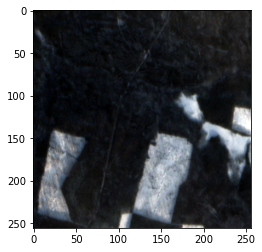

In [31]:
plt.imshow(satellite_image2rgb_image(io.imread(testImg)/65536,bands=[4,3,2]))